In [414]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pathlib import Path

import spikeinterface.core as si  # import core only
# from spikeinterface.core import load_extractor
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from probeinterface.plotting import plot_probe
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [415]:
# set directory path for reading/saving data
DATA_DIR = r"E:\Crick\neuropixels\Mouse1"
recording_filenames = [
    ("2025-03-20_11-35-19", "Record Node 105"),
    ("2025-03-21_15-05-41", "Record Node 105"),
    ("2025-03-21_17-53-00", "Record Node 101"),
    ("2025-03-21_17-56-47", "Record Node 105"),
    ("2025-03-25_11-50-51", "Record Node 105"),
    ("2025-03-25_12-05-37", "Record Node 105"),
    ("2025-03-25_12-29-58", "Record Node 105"),
    ("2025-03-25_12-40-32", "Record Node 105"),
    ("2025-03-25_12-48-14", "Record Node 105"),
]

In [416]:
# set global arguments for parallel processing
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

## 1. Read recording

In [417]:
# load data 
recording_data_index = 6
recording_date = recording_filenames[recording_data_index][0]
recording_node = recording_filenames[recording_data_index][1]

In [418]:
# # if loading previously preprocessed recording
# preprocessed_recording = si.load_extractor(f"{DATA_DIR}\{recording_date}\preprocessed_recording")
# print(preprocessed_recording)

In [419]:
# if loading raw recording (needs to be preprocessed)
data_path = f"{DATA_DIR}\{recording_date}\{recording_node}" # full data path (90GB) --> "E:\Crick\ephys_test\Record_Node_104"
print(data_path)
stream_names, stream_ids = se.get_neo_streams('openephysbinary', data_path)
print(stream_names)
print(stream_ids)

E:\Crick\neuropixels\Mouse1\2025-03-25_12-29-58\Record Node 105
['Record Node 105#NI-DAQmx-107.PXIe-6341', 'Record Node 105#Neuropix-PXI-100.ProbeA-AP', 'Record Node 105#Neuropix-PXI-100.ProbeA-LFP']
['0', '1', '2']


In [420]:
recording = se.read_openephys(data_path, stream_id="1", load_sync_channel=False) # want ProbeA-AP --> ['Record Node 101#NI-DAQmx-103.PXIe-6341', 'Record Node 101#Neuropix-PXI-100.ProbeA-AP', 'Record Node 101#Neuropix-PXI-100.ProbeA-LFP']
print('done')

done


In [421]:
print(recording)

OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 2,368,584 samples 
                                   78.95s (1.32 minutes) - int16 dtype - 1.69 GiB


In [422]:
# details about probe (optional)
recording.get_probe().to_dataframe()

,x,y,contact_shapes,width,shank_ids,contact_ids
0,16.0,3840.0,square,12.0,,e384
1,48.0,3840.0,square,12.0,,e385
2,0.0,3860.0,square,12.0,,e386
3,32.0,3860.0,square,12.0,,e387
4,16.0,3880.0,square,12.0,,e388
...,...,...,...,...,...,...
379,32.0,3780.0,square,12.0,,e379
380,16.0,3800.0,square,12.0,,e380
381,48.0,3800.0,square,12.0,,e381
382,0.0,3820.0,square,12.0,,e382


(-100.0, 100.0)

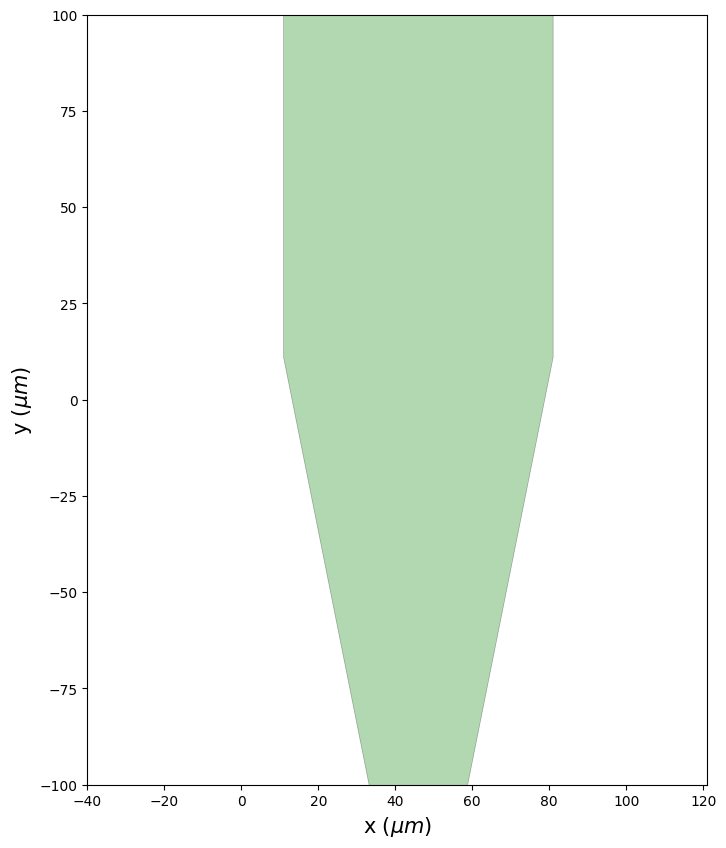

In [423]:
# details about probe (optional)
fig, ax = plt.subplots(figsize=(15,10))
sw.plot_probe_map(recording, ax=ax, with_channel_ids=True)
ax.set_ylim(-100, 100)

## 2. Preprocessing

In [424]:
rec1 = spre.highpass_filter(recording=recording, freq_min=400.)
bad_channel_ids, channel_labels = spre.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids: ', bad_channel_ids)

rec3 = spre.phase_shift(recording=rec2)
rec4 = spre.common_reference(recording=rec3, operator='median', reference='global')
preprocessed_recording = rec4
preprocessed_recording

C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\preprocessing\detect_bad_channels.py:333: RuntimeWarning: invalid value encountered in divide
  xcorr = np.sum(raw * ref[:, np.newaxis], axis=0) / np.sum(ref**2)


bad_channel_ids:  ['AP50' 'AP52' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP69' 'AP71' 'AP192']


CommonReferenceRecording: 365 channels - 30.0kHz - 1 segments - 2,368,584 samples 
                          78.95s (1.32 minutes) - int16 dtype - 1.61 GiB

In [425]:
# # plot details about preprocessing steps (optional)
# # this method is interactive (a bit laggy), the ones below are static
# %matplotlib widget
# sw.plot_traces({'filter': rec1, 'cmr': rec4}, backend='ipywidgets')

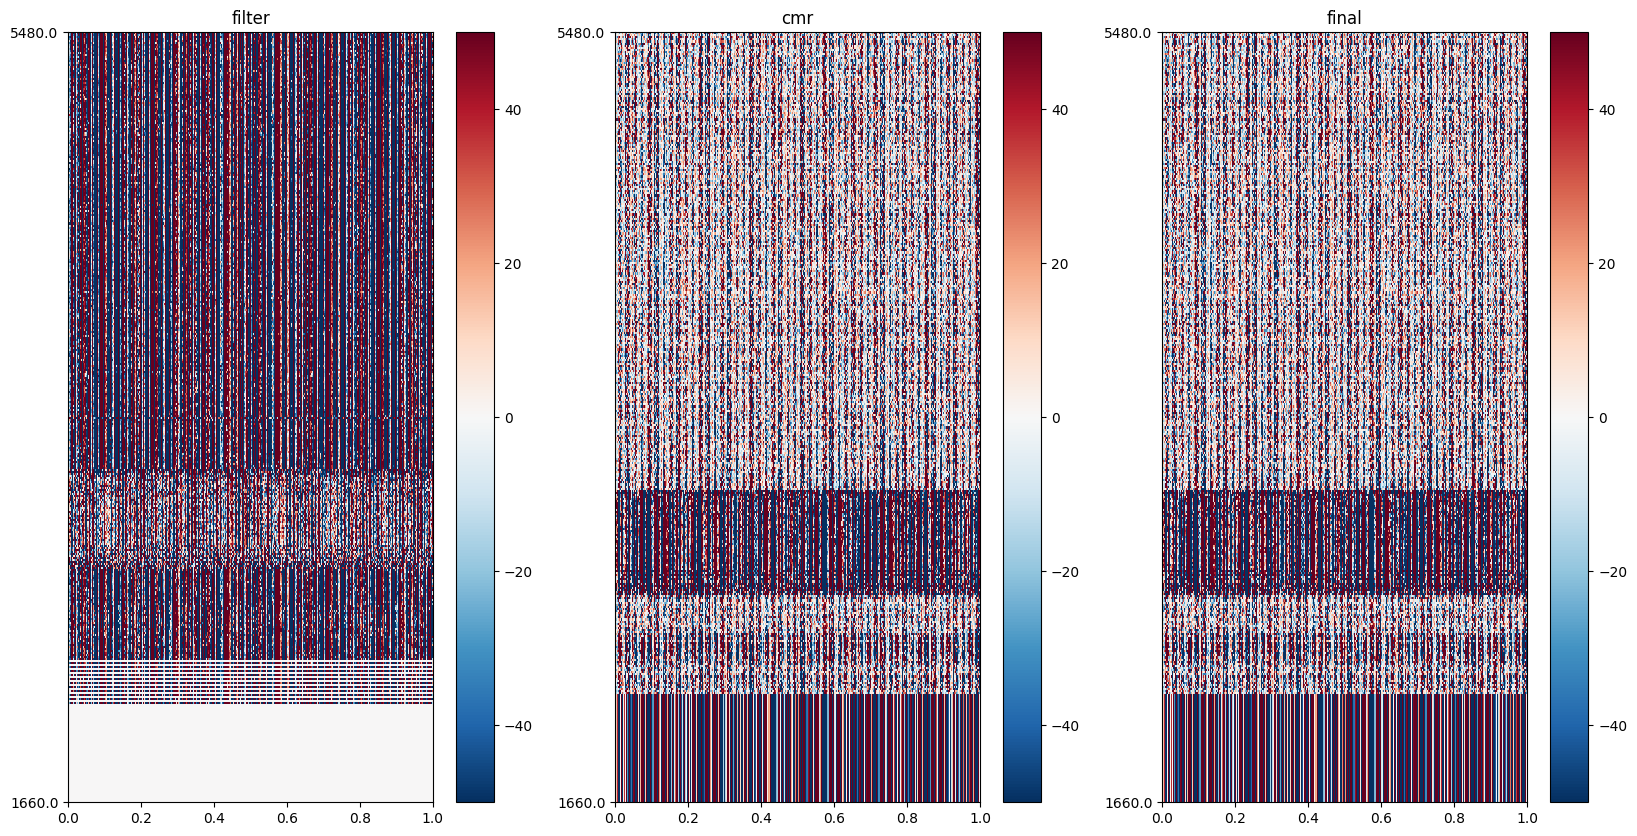

In [426]:
# plot details about preprocessing steps (optional)
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))
sw.plot_traces(rec1, backend='matplotlib', clim=(-50, 50), ax=axs[0])
sw.plot_traces(rec4, backend='matplotlib', clim=(-50, 50), ax=axs[1])
sw.plot_traces(preprocessed_recording, backend='matplotlib', clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)

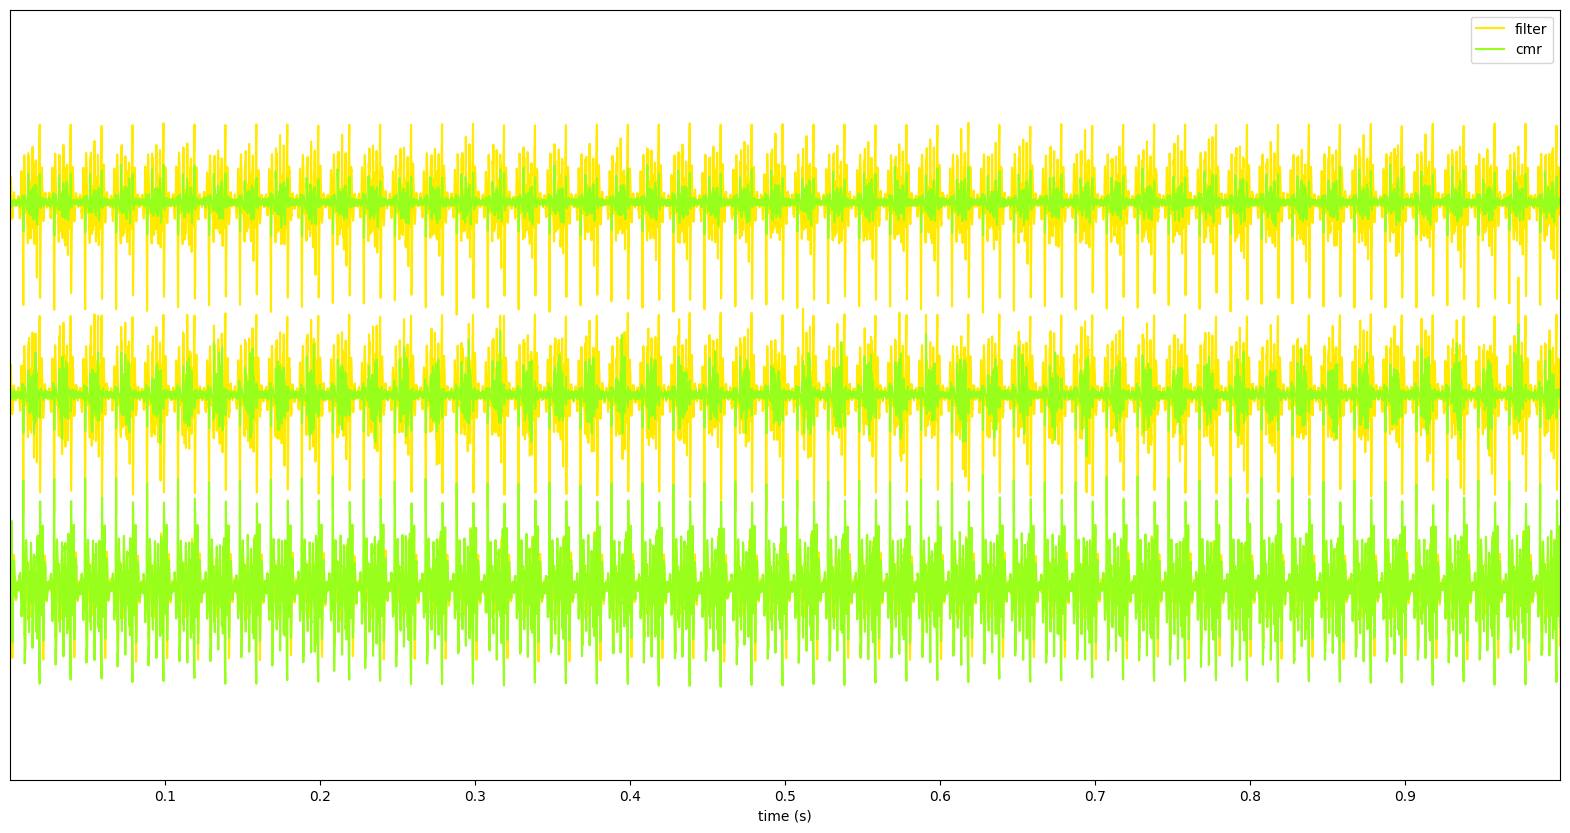

In [427]:
# plot some channels (optional)
fig, ax = plt.subplots(figsize=(20, 10))
some_chans = preprocessed_recording.channel_ids[[100, 150, 200, ]]
sw.plot_traces({'filter': rec1, 'cmr': rec4}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

In [428]:
# only run if preprocessed recording not already saved
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
preprocessed_recording = preprocessed_recording.save(format="binary", folder=f"{DATA_DIR}\{recording_date}_out\preprocessed_recording", **job_kwargs)
preprocessed_recording

write_binary_recording 
n_jobs=40 - samples_per_chunk=30,000 - chunk_memory=20.89 MiB - total_memory=835.42 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/79 [00:00<?, ?it/s]

BinaryFolderRecording: 365 channels - 30.0kHz - 1 segments - 2,368,584 samples 
                       78.95s (1.32 minutes) - int16 dtype - 1.61 GiB

In [429]:
# # load in existing preprocessed_recording if already created and saved
# preprocessed_recording = si.load_extractor(f"{DATA_DIR}\{recording_date}_out\preprocessed_recording")
# print(preprocessed_recording)

## 3. Check noise level

In [430]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(preprocessed_recording, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(preprocessed_recording, return_scaled=False)

Text(0.5, 0, 'noise  [microV]')

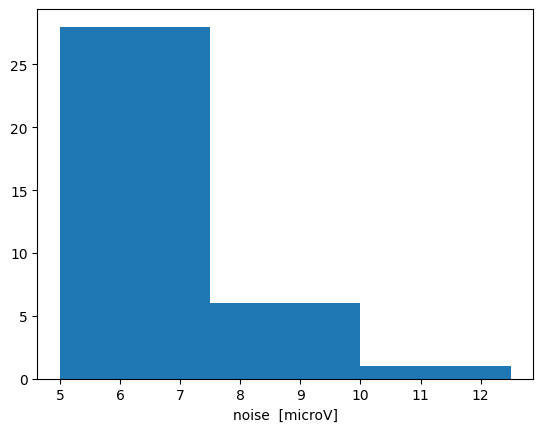

In [431]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 15, 2.5))
ax.set_xlabel('noise  [microV]')

Text(0.5, 0, 'noise  [microV]')

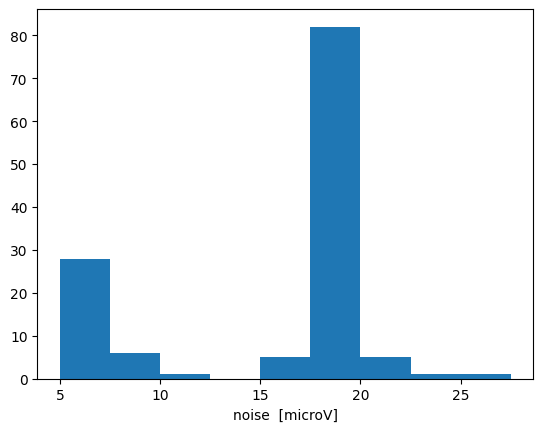

In [432]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')

## 4. Detect and localize peaks

In [433]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(preprocessed_recording,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
peaks

detect peaks using locally_exclusive:   0%|          | 0/79 [00:00<?, ?it/s]

array([(     18, 229, -140., 0), (     82, 229, -135., 0),
       (    236,  98, -573., 0), ..., (1952676, 316, -148., 0),
       (1952680, 277, -107., 0), (1952680, 348, -122., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

In [434]:
peak_locations = localize_peaks(preprocessed_recording, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

localize peaks using center_of_mass:   0%|          | 0/79 [00:00<?, ?it/s]

## 5. Check for drift (optional?)

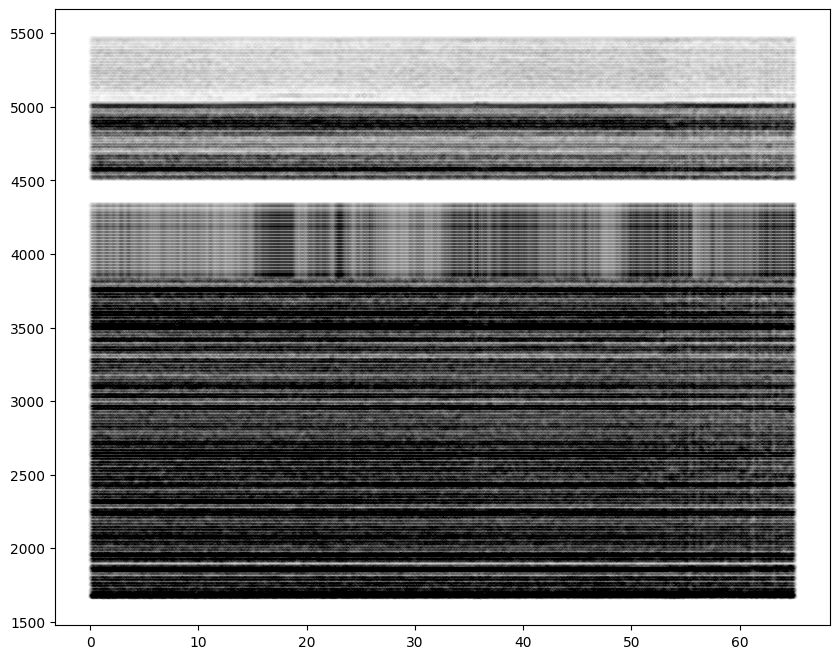

In [435]:
# check for drifts
fs = preprocessed_recording.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

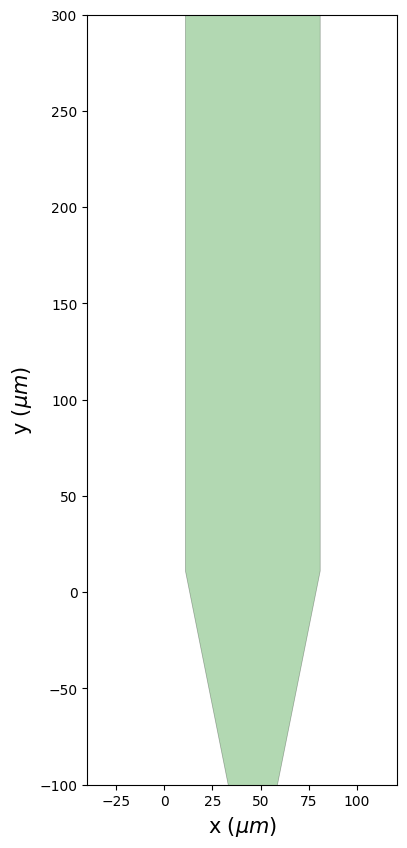

In [436]:
# we can also use the peak location estimates to have an insight of cluster separation before sorting
fig, ax = plt.subplots(figsize=(10, 10))
sw.plot_probe_map(preprocessed_recording, ax=ax, with_channel_ids=True)
ax.set_ylim(-100, 300)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

## 6. Run Spike Sorter

In [437]:
# check which sorters are implemented/available and which are installed
print("Available sorters", ss.available_sorters())
print("Installed sorters", ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'simple', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['kilosort4', 'simple', 'spykingcircus2', 'tridesclous', 'tridesclous2']


In [438]:
ss.get_default_sorter_params("kilosort4")
params_kilosort4 = {'do_correction': False}
print(params_kilosort4)

{'do_correction': False}


In [439]:
# run kilosort4 (specific to neuropixels)
sorting_kilo4 = ss.run_sorter(sorter_name="kilosort4", recording=preprocessed_recording, folder=f"{DATA_DIR}\{recording_date}_out\output_kilosort4", verbose=True, **params_kilosort4)
print(sorting_kilo4)

INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing preprocessing variables.
INFO:kilosort.run_kilosort:----------------------------------------
INFO:kilosort.run_kilosort:N samples: 2368584
INFO:kilosort.run_kilosort:N seconds: 78.9528
INFO:kilosort.run_kilosort:N batches: 40
INFO:kilosort.run_kilosort:Preprocessing filters computed in  1.87s; total  1.87s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Resource usage after preprocessing
INFO:kilosort.run_kilosort:********************************************************
INFO:kilosort.run_kilosort:CPU usage:     3.60 %
INFO:kilosort.run_kilosort:Memory:       12.86 %     |     65.78   /   511.65 GB
INFO:kilosort.run_kilosort:------------------------------------------------------
INFO:kilosort.run_kilosort:GPU usage:    N/A
INFO:kilosort.run_kilosort:GPU memory:   N/A
INFO:kilosort.run_kilosort:********************************************************
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing

Skipping drift correction.


INFO:kilosort.spikedetect:Number of universal templates: 1532
INFO:kilosort.spikedetect:Detecting spikes...
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [25:19<00:00, 37.99s/it]
INFO:kilosort.run_kilosort:238245 spikes extracted in  1551.96s; total  1553.89s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:First clustering
INFO:kilosort.run_kilosort:----------------------------------------
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.87s/it]
INFO:kilosort.run_kilosort:237 clusters found, in  136.44s; total  1690.33s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Extracting spikes using cluster waveforms
INFO:kilosort.run_kilosort:----------------------------------------
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [03:48<00:00,  5.70s/it]
INFO:kilosort.run_kilosort:364696 spikes extracted in  228.26s; tota

kilosort4 run time 2098.26s
KiloSortSortingExtractor: 141 units - 1 segments - 30.0kHz


In [440]:
print("Units found by kilo4:", sorting_kilo4.get_unit_ids())

Units found by kilo4: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]


## 7. Create sorting analyzer + compute postprocessing and metrics

In [441]:
# postprocessing --> SortingAnalyzer object = pairing BaseRecording and BaseSorting
# SortingAnalyzer can be loaded in memory or saved in a folder
# this folder contains waveforms, templates, and other postprocessing data
analyzer_kilo4 = si.create_sorting_analyzer(sorting=sorting_kilo4, recording=preprocessed_recording, format='binary_folder', folder=rf"{DATA_DIR}\{recording_date}_out\analyzer_kilo4_binary")

estimate_sparsity:   0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\core\basesorting.py:264: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


In [442]:
### NEUROPIXEL SPECIFIC -- https://spikeinterface.readthedocs.io/en/latest/how_to/analyze_neuropixels.html

In [443]:
analyzer_kilo4.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer_kilo4.compute("waveforms",  ms_before=1.5,ms_after=2., **job_kwargs)
analyzer_kilo4.compute("templates", operators=["average", "median", "std"])
analyzer_kilo4.compute("noise_levels")
analyzer_kilo4

compute_waveforms:   0%|          | 0/79 [00:00<?, ?it/s]

SortingAnalyzer: 365 channels - 141 units - 1 segments - binary_folder - sparse - has recording
Loaded 4 extensions: random_spikes, waveforms, templates, noise_levels

In [444]:
analyzer_kilo4.compute("correlograms")
analyzer_kilo4.compute("unit_locations")
analyzer_kilo4.compute("spike_amplitudes", **job_kwargs)
analyzer_kilo4.compute("template_similarity")
analyzer_kilo4

spike_amplitudes:   0%|          | 0/79 [00:00<?, ?it/s]

SortingAnalyzer: 365 channels - 141 units - 1 segments - binary_folder - sparse - has recording
Loaded 8 extensions: random_spikes, waveforms, templates, noise_levels, correlograms, unit_locations, spike_amplitudes, template_similarity

In [445]:
# quality metrics
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']
metrics = analyzer_kilo4.compute("quality_metrics").get_data()
metrics

C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,sd_ratio
0,4041,51.182479,1,1.29507,1.329605,825,1.0,641,<NA>,0.000875,-37.049999,<NA>,<NA>,0.327889,0.024251,0.0,81.26,1.249637
1,3358,42.53174,1,5.792265,1.626738,697,1.0,572,<NA>,0.000829,-24.6675,<NA>,<NA>,0.241513,0.010125,0.0,62.7,2.744287
2,4580,58.009342,1,12.963207,1.075217,857,1.0,607,<NA>,0.001418,-37.049999,<NA>,<NA>,0.221616,0.013319,0.0,75.62,2.101669
3,1434,18.16275,1,7.302749,0.486331,38,1.0,28,<NA>,0.5,-86.092499,<NA>,<NA>,0.491632,0.041841,0.000697,28.1,2.342595
4,3961,50.169215,1,5.653631,0.067096,40,0.070414,27,0.08,0.16092,-190.709991,<NA>,<NA>,0.723555,0.314819,0.006312,62.22,1.904518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,1779,22.53245,1,2.475893,0.074841,9,0.0,0,0.025,0.001341,-76.829994,<NA>,<NA>,0.185497,0.048904,0.008994,33.4,1.374222
137,1938,24.546311,1,1.814836,0.168171,24,0.032045,3,0.055,0.003525,-52.844997,<NA>,<NA>,0.288958,0.050052,0.000516,33.92,1.652215
138,1983,25.116272,1,2.638429,0.153932,23,0.01009,1,0.025,0.008291,-99.059998,<NA>,<NA>,0.369642,0.06354,0.0,36.88,1.699986
139,26,0.329311,1,4.295479,0.0,0,0.0,0,<NA>,<NA>,-122.849998,<NA>,<NA>,0.115385,0.038462,0.0,0.86,1.360599


In [447]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([  6,   7,   9,  10,  16,  19,  20,  28,  30,  31,  32,  33,  34,
        36,  37,  38,  40,  42,  43,  44,  46,  48,  49,  50,  58,  60,
        62,  67,  72,  73,  77,  79,  81,  86,  98, 100, 102, 103, 110,
       113, 114, 115, 116, 117, 118, 123, 124, 127, 128, 129, 130, 131,
       133, 134, 135, 136, 137, 138, 140])

In [448]:
analyzer_clean = analyzer_kilo4.select_units(keep_unit_ids, folder=rf"{DATA_DIR}\{recording_date}_out\analyzer_clean_no_presence_ratio", format='binary_folder')
analyzer_clean

SortingAnalyzer: 365 channels - 59 units - 1 segments - binary_folder - sparse - has recording
Loaded 9 extensions: random_spikes, waveforms, templates, noise_levels, correlograms, unit_locations, spike_amplitudes, template_similarity, quality_metrics

In [413]:
# # export spike sorting report to a folder
# sexp.export_report(analyzer_clean, rf"{DATA_DIR}\{recording_date}_out\report_clean", format='png')

In [449]:
# export spike sorting report to a folder
sexp.export_report(analyzer_clean, rf"{DATA_DIR}\{recording_date}_out\report_clean_no_presence_ratio", format='png')

In [450]:
# export spike sorting report to a folder
sexp.export_report(analyzer_kilo4, rf"{DATA_DIR}\{recording_date}_out\report_before_clean", format='png')

In [ ]:
# analyzer_clean = si.load_sorting_analyzer(rf"{DATA_DIR}\{recording_date}_out\analyzer_clean")
# analyzer_clean

In [451]:
# # load in existing sorting analyzer if already created and saved
# analyzer_kilo4 = si.load_sorting_analyzer(rf"{DATA_DIR}\{recording_date}_out\analyzer_kilo4_binary", load_extensions=True)
# analyzer_kilo4

## 9. Export to Phy (for manual curation)

In [452]:
# alternatively, export data locally to Phy
# Phy --> GUI for manual curation of spike sorting output
sexp.export_to_phy(analyzer_kilo4, rf"{DATA_DIR}\{recording_date}_out\phy_folder", verbose=True)

write_binary_recording:   0%|          | 0/79 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/141 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/141 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/79 [00:00<?, ?it/s]

Run:
phy template-gui  E:\Crick\neuropixels\Mouse1\2025-03-25_12-29-58_out\phy_folder\params.py


In [ ]:
# after curating with Phy, reload the "curated sorting" 
# exclude units labeled as "noise"
sorting_curated_phy = se.read_phy(rf"{DATA_DIR}\{recording_date}_out\phy_folder", exclude_cluster_groups=["noise"])
print(sorting_curated_phy)

In [ ]:
# after curating with Phy, reload the "curated sorting" 
# exclude units labeled as "noise" and "mua"
sorting_curated_phy = se.read_phy(rf"{DATA_DIR}\{recording_date}_out\phy_folder", exclude_cluster_groups=["noise", "mua"])
print(sorting_curated_phy)

In [453]:
#### trying to look at plots relating to paper
recording_data_index = 2
recording_date = recording_filenames[recording_data_index][0]
recording_node = recording_filenames[recording_data_index][1]
# load in existing sorting analyzer if already created and saved
analyzer_loaded = si.load_sorting_analyzer(rf"{DATA_DIR}\{recording_date}_out\analyzer_kilo4_binary", load_extensions=True)
analyzer_loaded
metrics = analyzer_loaded.compute("quality_metrics").get_data()
metrics


C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:156: UserWarning: Bin duration of 60s is larger than recording duration. Presence ratios are set to NaN.
  warnings.warn(
C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


calculate_pc_metrics:   0%|          | 0/82 [00:00<?, ?it/s]

C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\pandas\core\dtypes\cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\pandas\core\dtypes\cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,sync_spike_4,sync_spike_8,firing_range,sd_ratio,isolation_distance,l_ratio,d_prime,silhouette,nn_hit_rate,nn_miss_rate
0,870,19.781359,<NA>,3.60126,0.232426,12,0.059901,2,0.125,0.002639,...,0,0,4.13,0.836406,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,112,2.546566,<NA>,0.554228,3.506122,3,1.0,1,<NA>,<NA>,...,0,0,1.06,0.998363,190.924321,0.016662,1.245177,0.010342,0.002874,0.002951
2,403,9.163089,<NA>,1.152653,0.0,0,0.0,0,0.21,<NA>,...,0,0,4.92,1.10188,76.203339,3.871713,1.487095,0.004595,0.023885,0.008956
3,265,6.025357,<NA>,0.561265,0.0,0,0.0,0,<NA>,<NA>,...,0,0,2.85,1.040894,82.766204,2.811362,0.834995,0.004697,0.012136,0.010287
4,562,12.778303,<NA>,2.452697,0.046416,1,0.0,0,0.13,0.004191,...,0,0,4.24,0.985695,164.749661,0.048524,5.277923,0.059526,0.249,0.001911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,69,1.568866,<NA>,0.471876,0.0,0,0.0,0,<NA>,<NA>,...,0,0,1.45,0.979064,2050838159196704.0,<NA>,1.402889,0.011203,0.009434,0.002564
78,632,14.369907,<NA>,1.249552,0.440442,12,0.521224,7,<NA>,0.008835,...,0,0,3.95,1.168506,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
79,107,2.43288,<NA>,0.556822,0.0,0,0.0,0,<NA>,<NA>,...,0,0,2.19,1.183623,242.027523,0.019556,1.111219,0.007451,0.009036,0.003302
80,159,3.615214,<NA>,1.672226,0.0,0,0.0,0,<NA>,<NA>,...,0,0,1.52,1.054679,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


C:\Users\Workstation3\anaconda3\envs\si_env\Lib\site-packages\spikeinterface\widgets\metrics.py:65: UserWarning: Skipping ['presence_ratio'] because they contain all NaNs
  warnings.warn(f"Skipping {nan_metrics} because they contain all NaNs")


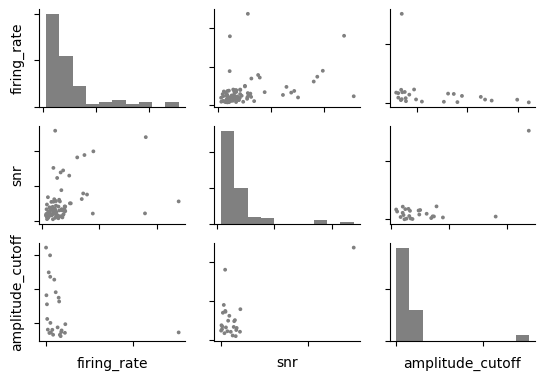

In [456]:
sw.plot_quality_metrics(analyzer_loaded, include_metrics=metric_names)
plt.show()